<a href="https://colab.research.google.com/github/ashen-pabasara/CNN-traffic_sign_classification/blob/main/traffic_sign_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Upload Kaggel API token (kaggle.json)
print("Upload your kaggle.json (from your Kaggle account -> Account -> Create API token)")
files.upload()

# move kaggle.json into correct place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Link for the dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train.csv

# Kaggel dataset config
dataset_slug = 'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
zip_file = 'gtsrb-german-traffic-sign.zip'
extract_dir = 'GTSRB'

!kaggle datasets download -d {dataset_slug} -p /content

# unzip the downloaded archive
!unzip /content/{zip_file} -d /content/{extract_dir}

Upload your kaggle.json (from your Kaggle account -> Account -> Create API token)


Streaming output truncated to the last 5000 lines.
  inflating: /content/GTSRB/train/5/00005_00053_00010.png  
  inflating: /content/GTSRB/train/5/00005_00053_00011.png  
  inflating: /content/GTSRB/train/5/00005_00053_00012.png  
  inflating: /content/GTSRB/train/5/00005_00053_00013.png  
  inflating: /content/GTSRB/train/5/00005_00053_00014.png  
  inflating: /content/GTSRB/train/5/00005_00053_00015.png  
  inflating: /content/GTSRB/train/5/00005_00053_00016.png  
  inflating: /content/GTSRB/train/5/00005_00053_00017.png  
  inflating: /content/GTSRB/train/5/00005_00053_00018.png  
  inflating: /content/GTSRB/train/5/00005_00053_00019.png  
  inflating: /content/GTSRB/train/5/00005_00053_00020.png  
  inflating: /content/GTSRB/train/5/00005_00053_00021.png  
  inflating: /content/GTSRB/train/5/00005_00053_00022.png  
  inflating: /content/GTSRB/train/5/00005_00053_00023.png  
  inflating: /content/GTSRB/train/5/00005_00053_00024.png  
  inflating: /content/GTSRB/train/5/00005_00053_0

In [3]:

# Define paths & parameters
train_dir = "/content/GTSRB/Train"
test_dir = "/content/GTSRB"
meta_file = "/content/GTSRB/Test.csv"
img_size = (48, 48)
batch_size = 128

# Numeric folder sort
class_names = sorted(os.listdir(train_dir), key=lambda x: int(x))
print("Class names:", class_names)

# Load train/validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=class_names
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=class_names
)

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']
Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [4]:
# Load test dataset from CSV
df_test = pd.read_csv(meta_file)

X_test, y_test = [], []
for i, row in df_test.iterrows():
    img_path = os.path.join(test_dir, row["Path"])
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    X_test.append(img)
    y_test.append(row["ClassId"])

X_test = np.array(X_test) / 255.0
y_test = np.array(y_test)
print("Test shape:", X_test.shape)

# Convert test to tf.data
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Number of classes:", len(class_names))

Test shape: (12630, 48, 48, 3)
Number of classes: 43


In [5]:
# Mapping sign names
sign_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}


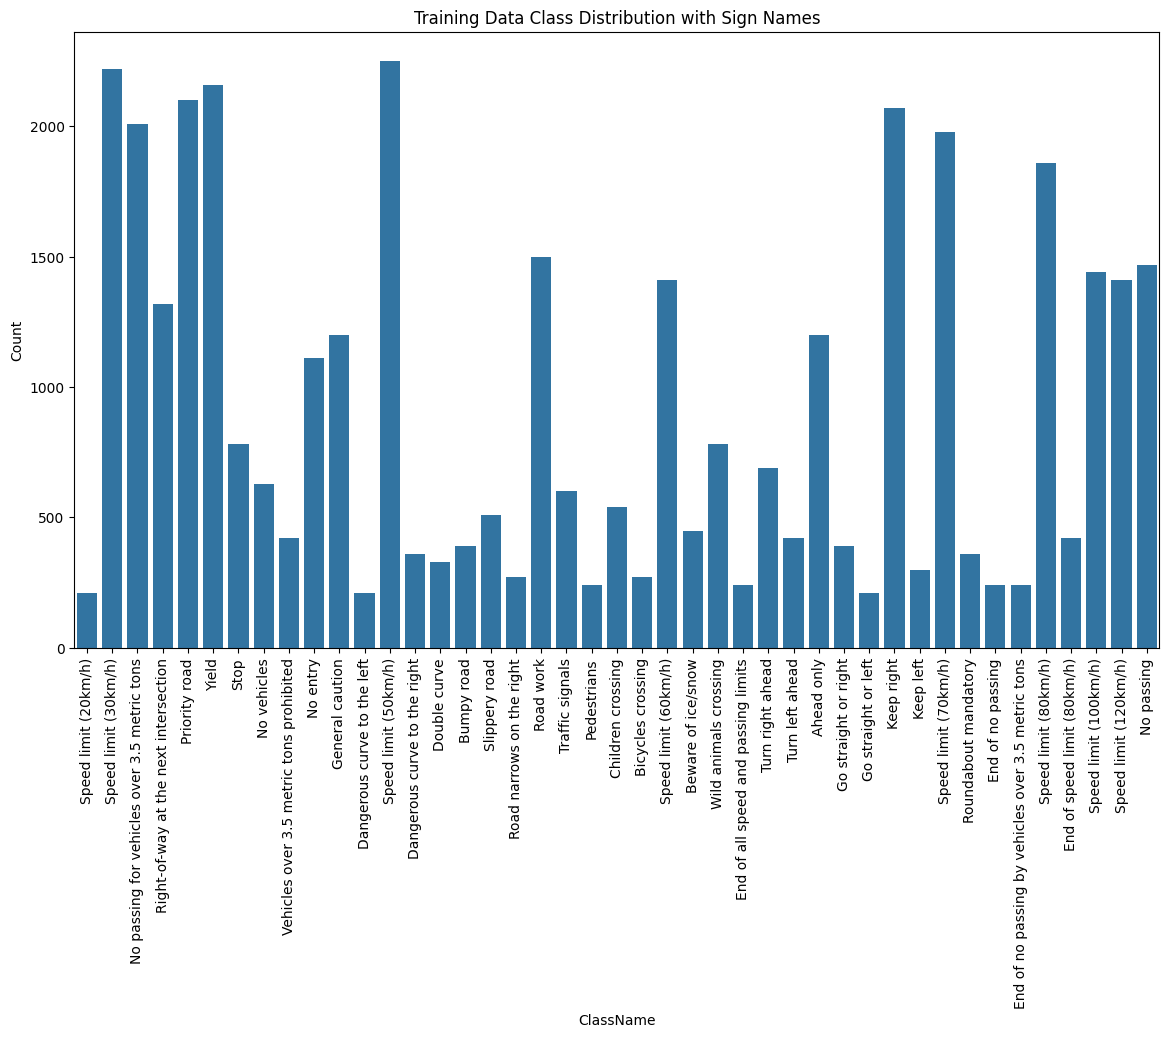

In [6]:
# Count images per class folder
counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        counts[class_name] = len(os.listdir(class_path))

# Convert to dataframe for plotting
df = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])

df["ClassName"] = df["Class"].astype(int).map(sign_names)

plt.figure(figsize=(14,8))
sns.barplot(x="ClassName", y="Count", data=df, order=df.sort_values("Class")["ClassName"])
plt.xticks(rotation=90)
plt.title("Training Data Class Distribution with Sign Names")
plt.show()


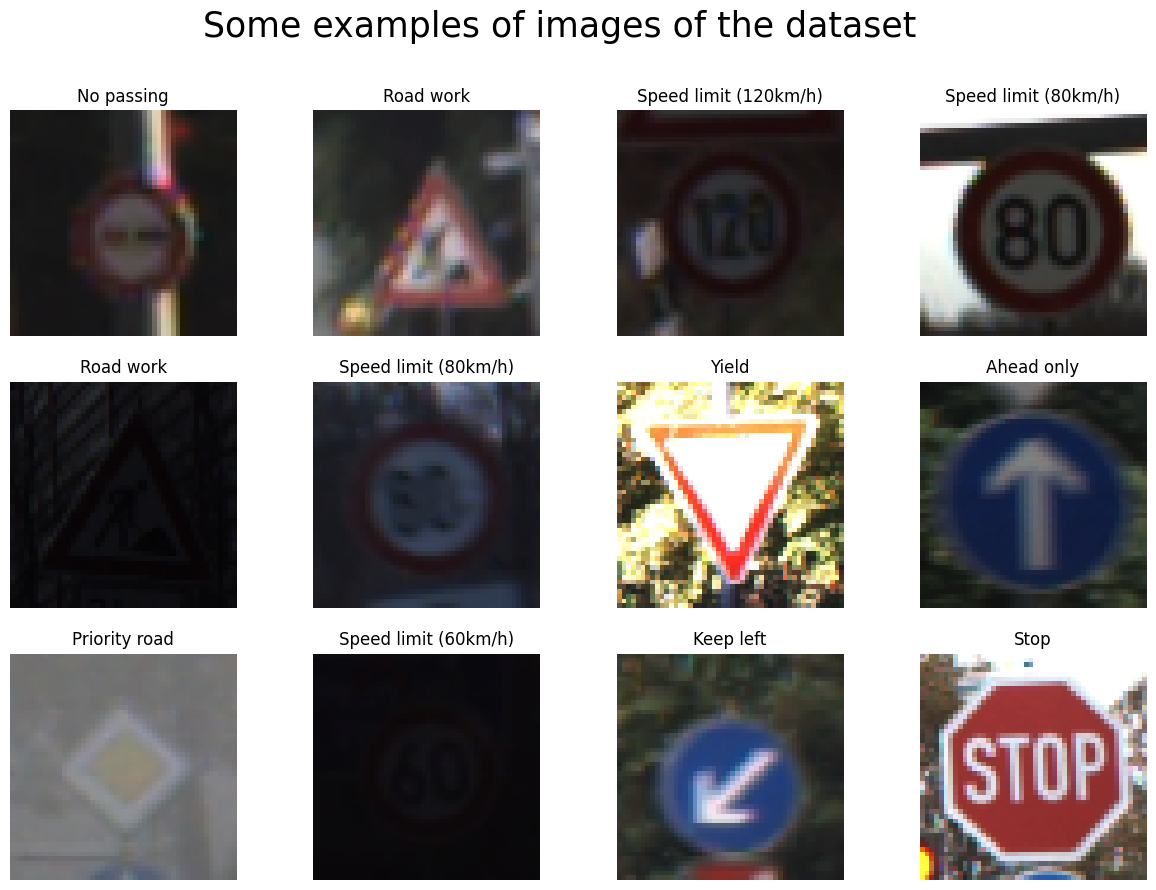

In [7]:
import matplotlib.pyplot as plt

# Show a batch of images with labels
plt.figure(figsize=(15,10))
plt.suptitle("Some examples of images of the dataset", fontsize=25)
for images, labels in train_ds.take(1):   # take one batch
    for i in range(12):   # show random 12 images
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_id = int(labels[i])
        plt.title(sign_names[label_id])
        plt.axis("off")


In [8]:
# Normalize data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build CNN Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.50))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.10))
model.add(Dense(43, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Show summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 44, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833,899 (33.70 MB)

 Trainable params: 8,833,899 (33.70 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

epochs = 25

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.5443 - loss: 1.7365 - val_accuracy: 0.9762 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 2/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9688 - loss: 0.1112 - val_accuracy: 0.9844 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 3/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9861 - loss: 0.0467 - val_accuracy: 0.9895 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 4/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9885 - loss: 0.0374 - val_accuracy: 0.9926 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 5/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9911 - loss: 0.0273 - val_accuracy: 0.9916 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 6/25
246/246 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9952 - loss: 0.0141 - val_accuracy: 0.9920 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 7/25
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9942 - lo

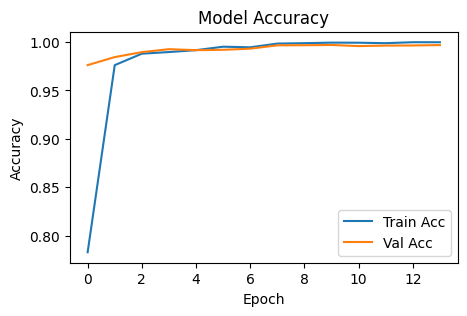

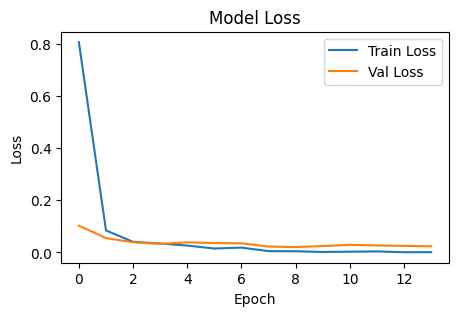

In [11]:
import matplotlib.pyplot as plt

# Train vs validation accuracy plot
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train vs validation loss plot
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Classification report for predtictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        60
           1       0.81      0.90      0.85       720
           2       0.89      0.98      0.93       750
           3       0.99      0.89      0.94       450
           4       0.98      0.91      0.95       660
           5       0.79      0.89      0.84       630
           6       0.93      0.75      0.83       150
           7       0.91      0.90      0.91       450
           8       0.96      0.86      0.91       450
           9       0.79      0.99      0.88       480
          10       0.76      0.96      0.85       660
          11       0.88      0.99      0.93       420
          12       0.30      0.31      0.31       690
          13       0.89      0.99      0.94       720
          14       0.00      0.00      0.00       270
          15       0.86      0.42      0.56       210
          16    

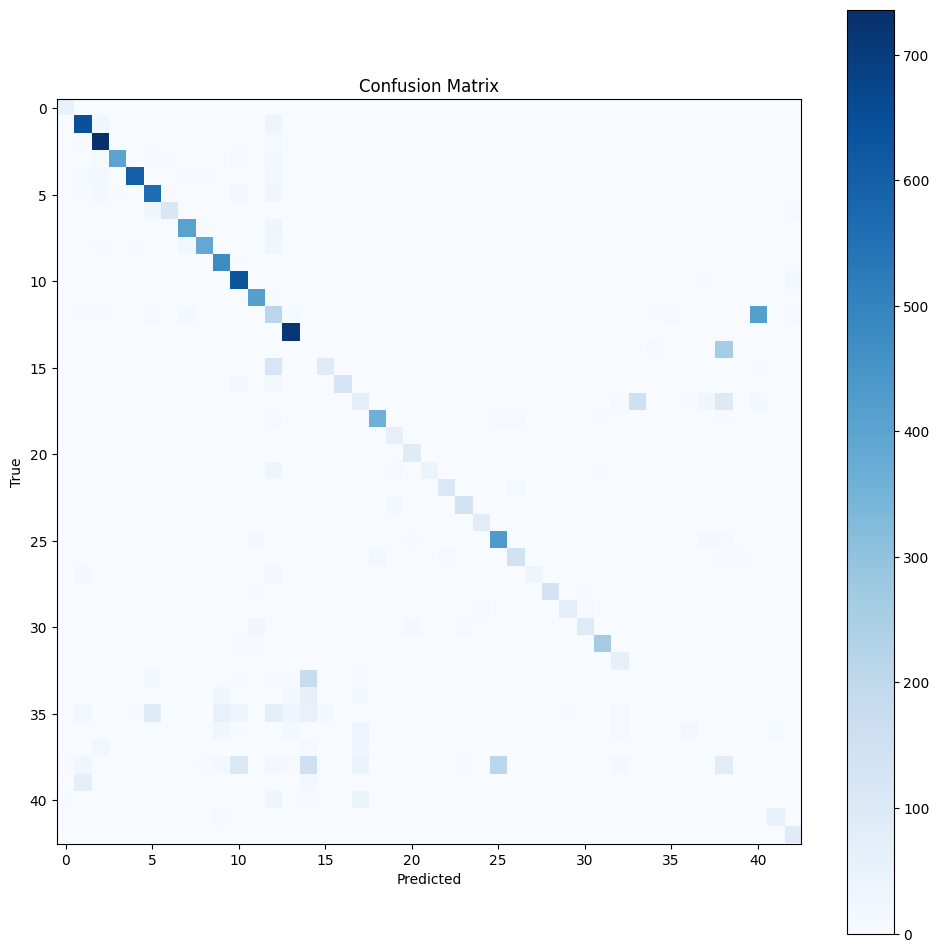

In [13]:
# Plot confusion matrix

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12,12))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [15]:
# Save the model
model.save("traffic_sign_cnn.keras")

# Check model size
size_mb = os.path.getsize("traffic_sign_cnn.h5") / (1024*1024)
print(f"Model size: {size_mb:.2f} MB")


Model size: 101.15 MB
